### 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝

XGBoost나 LightGBM은 성능이 매우 뛰어난 알고리즘 이지만 하이퍼 파라미터 개수가 다른 알고리즘에 비해서 많다.  
실무의 대용량 학습 데이터에 Grid Search 방식으로는 많은 시간이 소요됨

때문에, 실무의 대용량 학습 데이터에 XGBoost나 LightGBM의 하이퍼 파라미터 튜닝 시에 Grid Search 방식보다는 다른 방식을 적용한다. 대표적인게 베이지안 최적화 기법이다.

### 베이지안 최적화 개요
베이지안 최적화는 목적 함수 식을 제대로 알 수 없는 블랙 박스 형태의 함수에서 최대 또는 최소 함수 반환 값을 만드는 최적 입력값을 가능한 적은 시도를 통해 빠르고 효과적으로 찾아주는 방식이다.

베이지안 최적화는 베이지안 확률에 기반을 두고 있는 최적화 기법이다.  
베이지안 확률이 새로운 사건의 관측이나 새로운 샘플 데이터를 기반으로 사후 확률을 개선해 나가듯이, 베이지안 최적화는 새로운 데이터를 입력받았을 때 최적 함수를 예측하는 사후 모델을 개선해 나가면서 최적 함수 모델을 만들어 낸다.

구성요소로 대체 모델(Surrogate Model)과 획득 함수(Acquisition Function)이 있다.

대체 모델은 획득 함수로부터 최적 함수를 예측할 수 있는 입력값을 추천 받은 뒤 이를 기반으로 최적 함수 모델을 개선해 나가며, 획득 함수는 개선된 대체 모델을 기반으로 최적 입력값을 계산한다. 대체 모델은 하이퍼 파라미터를 입력받으면서 점차 개선되어, 대체 모델을 기반으로 더 정확한 하이퍼 파라미터를 계산할 수 있게 된다.

step1 : 랜덤한 하이퍼 파라미터 샘플링, 성능 관측  
step2 : 관측값 기반으로 최적 함수 추정  
step3 : 최적함수 기반으로 획득 함수는 다음으로 관측할 하이퍼 파라미터 값을 계산한다.
획득 함수는 이전의 최적 관측값보다 더 큰 최댓값을 가질 가능성이 높은 지점을 찾아서 다음에 관측할 하이퍼 파라미터를 대체 모델에 전달한다.  
step4 : 획득 함수로부터 하이퍼 파라미터를 수행하여 관측된 값을 기반으로 대체 모델은 갱신되어 다시 최적 함수를 예측 추정한다.

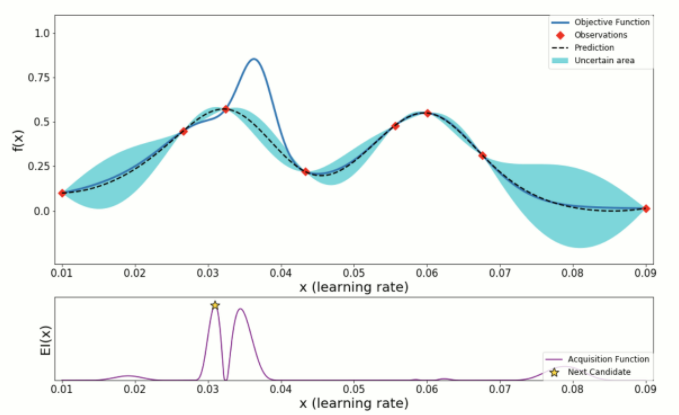

### HyperOpt 사용하기
베이지안 최적화를 모델에 적용시켜주는 패키지  

In [1]:
!pip install hyperopt

In [3]:
from hyperopt import hp
search_space = {'x':hp.quniform('x',-10,10,1), 'y':hp.quniform('y',-15,15,1)}

In [4]:
from hyperopt import STATUS_OK

def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y
    
    return retval

In [8]:
from hyperopt import fmin, tpe, Trials
import numpy as np
trial_val = Trials()

best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5,
              trials=trial_val, rstate= np.random.default_rng(seed=0))
print('best:',best_01)

100%|██████████| 5/5 [00:00<00:00, 999.26trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


In [10]:
trial_val = Trials()

best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20,
              trials=trial_val, rstate= np.random.default_rng(seed=0))
print('best:',best_02)

100%|██████████| 20/20 [00:00<00:00, 1110.09trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


직관적으로 확인

In [15]:
import pandas as pd

losses = [loss_dict['loss'] for loss_dict in trial_val.results]
result_df = pd.DataFrame({'x':trial_val.vals['x'], 'y':trial_val.vals['y'], 'losses':losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


### HyperOPT이용 XGBoost 하이퍼 파라미터 최적화